# Benchmarking the Simth form computation in SageMath and Kenzo

Importing Kenzo and some auxiliary functions to convert matrices back and forth, and call kenzo function

In [1]:
from sage.interfaces.kenzo import *
smith = EclObject("smith")
decl = """
(DEFUN COPY-ARRAY-MTRX (mtrx)
  (declare (type array mtrx))
   (the matrix
        (let ((line-n (line-number mtrx))
              (column-n (column-number mtrx)))
          (declare (fixnum line-n column-n))
          (let ((rslt (make-array (list line-n column-n)
                                  :element-type 'fixnum)))
            (declare (type matrix rslt))
            (dotimes (il line-n)
              (declare (fixnum il))
              (dotimes (ic column-n)
                (declare (fixnum ic))
                (setf (aref rslt il ic) (aref mtrx il ic))))
        rslt))))
"""
ecl_eval(decl)
copy_array_matrix = EclObject("copy-array-mtrx")
kenzosmith = lambda m: [k2s_matrix(a) for a in smith(copy_array_matrix(s2k_matrix(m)))]



Profiling function

In [2]:
import time
def profile_sparse_matrix(size, entries, coefsize=3):
    M = Matrix(ZZ, size)
    for count in range(entries):
        i = randint(0, size-1)
        j = randint(0, size-1)
        M[i,j] = randint(-coefsize, coefsize)
    startsage = time.perf_counter()
    resage = M.smith_form()
    endsage = time.perf_counter()
    reskenzo = kenzosmith(M)
    endkenzo = time.perf_counter()
    return (endsage-startsage, endkenzo-endsage)

Running times for sparse matrices

10% of nonzero entries

X-axis: matrix size

Y-axis: time in seconds

- Blue: SageMath via Pari
- Red: Kenzo

In [3]:
results10 = {i: profile_sparse_matrix(i,i^2//10) for i in range(8, 100)}

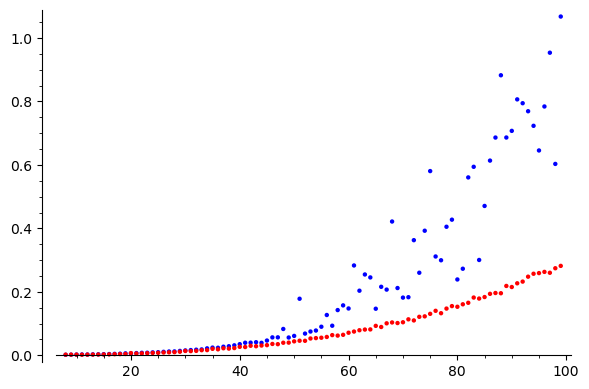

In [39]:
list_plot([(a[0],a[1][0]) for a in results10.items()]) + list_plot([(a[0],a[1][1]) for a in results10.items()], color='red')

Running times for sparse matrices

20% of nonzero entries

X-axis: matrix size 

Y-axis: time in seconds

- Blue: SageMath via 
- Pari Red: Kenzo


In [43]:
results20 = {i: profile_sparse_matrix(i,i^2//5) for i in range(8, 100)}

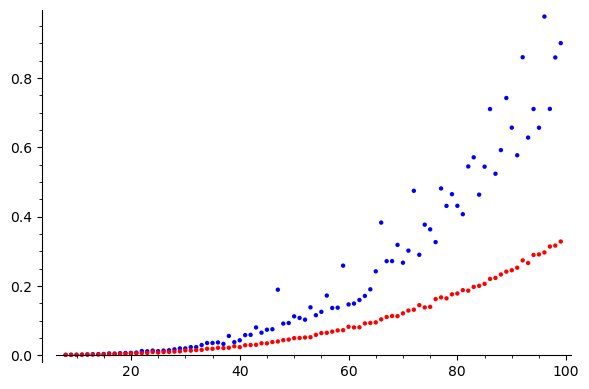

In [44]:
list_plot([(a[0],a[1][0]) for a in results20.items()]) + list_plot([(a[0],a[1][1]) for a in results20.items()], color='red')

Running times for sparse matrices

50% of nonzero entries

X-axis: matrix size 

Y-axis: time in seconds

- Blue: SageMath via Pari
- Red: Kenzo


In [45]:
results50 = {i: profile_sparse_matrix(i,i^2//2) for i in range(8, 100)}

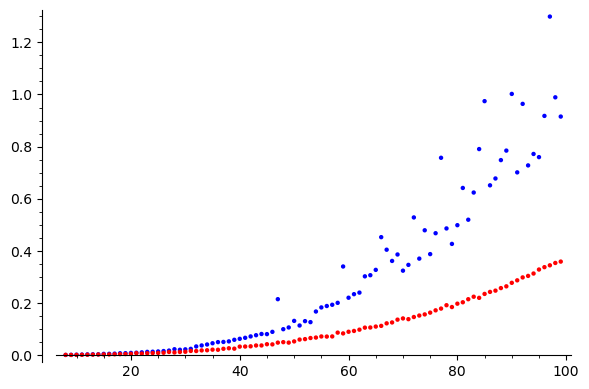

In [46]:
list_plot([(a[0],a[1][0]) for a in results50.items()]) + list_plot([(a[0],a[1][1]) for a in results50.items()], color='red')

In [4]:
def profile_dense_matrix(size, coefsize=3):
    M = random_matrix(ZZ, size)
    startsage = time.perf_counter()
    resage = M.smith_form()
    endsage = time.perf_counter()
    reskenzo = kenzosmith(M)
    endkenzo = time.perf_counter()
    return (endsage-startsage, endkenzo-endsage)

Running times for dense matrices


X-axis: matrix size

Y-axis: time in seconds

- Blue: SageMath via Pari 
- Red: Kenzo


In [5]:
resultsdense = {i: profile_dense_matrix(i) for i in range(8, 100)}

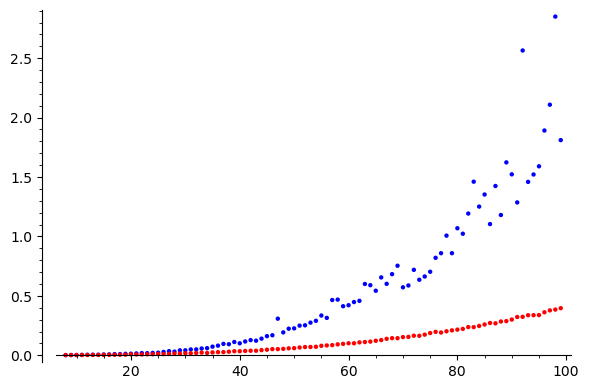

In [51]:
list_plot([(a[0],a[1][0]) for a in resultsdense.items()]) + list_plot([(a[0],a[1][1]) for a in resultsdense.items()], color='red')

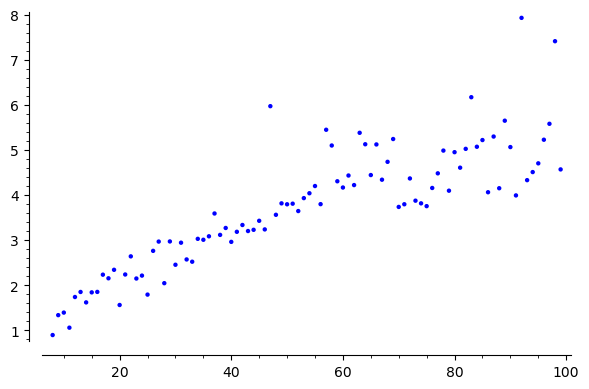

In [52]:
list_plot([(a[0],a[1][0]/a[1][1]) for a in resultsdense.items()])

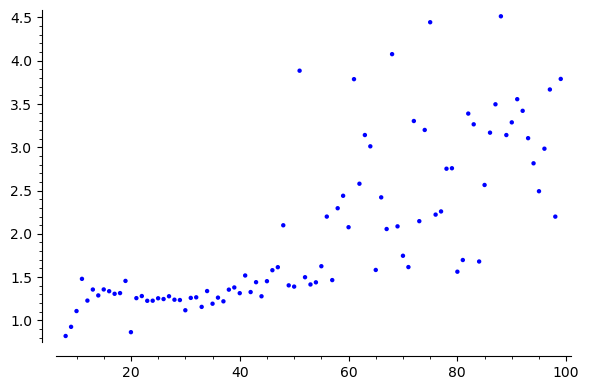

In [53]:
list_plot([(a[0],a[1][0]/a[1][1]) for a in results10.items()])

In [128]:
var('a,b,c,d,e,f')
model(x)=a+b*x+c*x^2+d*x^3

In [129]:
fit1 = find_fit([[a[0],a[1][0]] for a in resultsdense.items()],model)
fit2 = find_fit([[a[0],a[1][1]] for a in resultsdense.items()],model)
fit1,fit2

([a == -0.08264165973932089,
  b == 0.00839716369236807,
  c == -0.00023363024800688805,
  d == (3.8115899616750535e-06)],
 [a == 0.0005985657953377625,
  b == (1.110907383996059e-05),
  c == (7.3597395561933284e-06),
  d == (3.30516230422834e-07)])

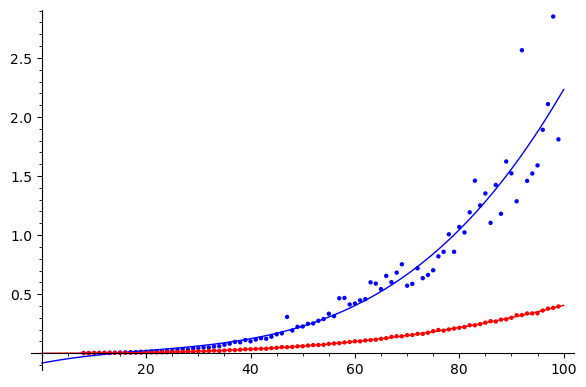

In [130]:
pl = list_plot([[a[0],a[1][0]] for a in resultsdense.items()]) 
pl += plot(model.subs(fit1),(x,0,100))
pl += list_plot([[a[0],a[1][1]] for a in resultsdense.items()],color='red')
pl += plot(model.subs(fit2),(x,0,100),color='red')
pl

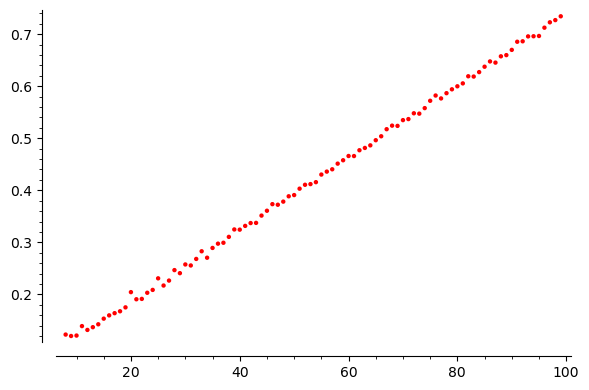

In [120]:
list_plot([[a[0],a[1][1]^(0.3333)] for a in resultsdense.items()],color='red')

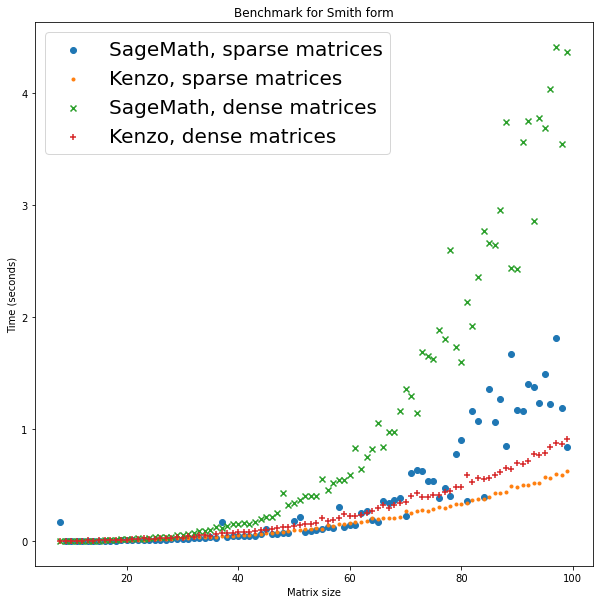

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
x = list(results10.keys())
y1 = [results10[i][0] for i in x]
y2 = [results10[i][1] for i in x]
y3 = [resultsdense[i][0] for i in x]
y4 = [resultsdense[i][1] for i in x]
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
      
ax1.scatter(x, y1, label='SageMath, sparse matrices')
ax1.scatter(x, y2, label='Kenzo, sparse matrices',marker = '.')
ax1.scatter(x, y3, label='SageMath, dense matrices', marker='x')
ax1.scatter(x, y4, label='Kenzo, dense matrices',marker='+')
#ax1.set_yscale("symlog", base=10) #the log transformation
#x1.set_yscale('symlog', linthresh=0.1)
ax1.set_title("Benchmark for Smith form")
ax1.set_xlabel("Matrix size")
ax1.set_ylabel("Time (seconds)");
#ax1.set_yticks([0.1,1,10, 50, 200, 500,1000, 2000, 6000])
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(fontsize=20)
plt.savefig("benchmarks_smith.png", format="png", dpi=int(600))
plt.show()